In [1]:
%%capture --no-stderr
%pip install -U  langgraph


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from typing import TypedDict, List, Optional, Annotated

class Log(TypedDict):
    id : str
    question : str
    docs : Optional[List]
    answer : str
    grade : Optional[int]
    grader : Optional[str]
    feedback : Optional[str]

- Now a failure analysis sub-graph. It uses FailureAnalysisState

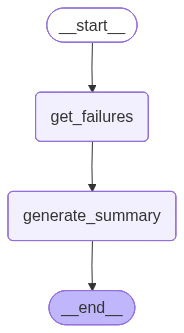

In [3]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class FailureAnalysisState(TypedDict):
    cleaned_logs : List[Log]
    failures : List[Log]
    fa_summary : str
    processed_logs : List[str]

class FailureAnalysisStateOutput(TypedDict):
    fa_summary : str
    processed_logs : List[Log]

def get_failures(state):
    """Get all the logs that contain failures"""

    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "failed" in log]
    return {"failures" : failures}

def generate_summary(state):
    """Generate a summary of failures"""

    failures = state["failures"]
    fa_summary = "Here there will be a function to summarize the failures."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure["id"]}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState, output_schema=FailureAnalysisStateOutput)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

fa_graph = fa_builder.compile()

display(Image(fa_graph.get_graph().draw_mermaid_png()))



- Now a question summarization graph. It uses QuestionSummarizationState

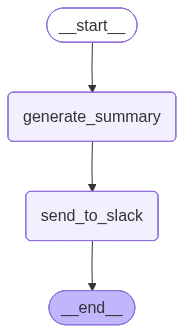

In [4]:
class QuestionSummarizationState(TypedDict):
    cleaned_logs : List[Log]
    qs_summary : str
    report : str
    processed_logs : List[str]

class QuestionSummarizationStateOutput(TypedDict):
    report : str
    processed_logs : List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"] 
    summary = "Here there will be a function  that will generate a summary of questions"
    return {"qs_summary" : summary, "processed_logs" : [f"summary-on-log-{Log["id"]}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    report = "Slack report foo bar baz"
    return {"report" : report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationStateOutput)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))